In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from coordination_numbers_calculation.utilities import chirality, half_time, sample_contour_plot, predictions_df, hanging_line
import matplotlib
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

### This dataset has the data collected on the (100), (110), (111) samples with the GCN features pre-calculated

In [116]:
# Load Data
df_full = pd.read_csv('data/experimental_data_with_gcn_features.csv')
#Adjust display options
pd.set_option('display.max_columns', 100)
#Display Data
df_full.head(5)

,normal_miller_index,x_coordinate(mm),y_coordinate(mm),molecule,h,k,l,surface_chirality,halftime(s),stereographic_projection_x,stereographic_projection_y,GCN Density 4.75,GCN Density 4.833,GCN Density 4.917,GCN Density 5.0,GCN Density 5.083,GCN Density 5.167,GCN Density 5.417,GCN Density 5.5,GCN Density 5.583,GCN Density 5.667,GCN Density 5.75,GCN Density 5.833,GCN Density 5.917,GCN Density 6.0,GCN Density 6.167,GCN Density 6.25,GCN Density 6.333,GCN Density 6.417,GCN Density 6.5,GCN Density 6.583,GCN Density 6.667,GCN Density 6.75,GCN Density 6.833,GCN Density 6.917,GCN Density 7.0,GCN Density 7.083,GCN Density 7.167,GCN Density 7.25,GCN Density 7.333,GCN Density 7.417,GCN Density 7.5,GCN Density 7.583,GCN Density 7.667,GCN Density 7.75,GCN Density 7.833,GCN Density 7.917,GCN Density 8.0,GCN Density 8.083,GCN Density 8.167,GCN Density 8.25,GCN Density 8.333,GCN Density 8.417,GCN Density 8.5,GCN Density 8.583,GCN Density 8.667,GCN Density 8.75,GCN Density 8.833,GCN Density 8.917,GCN Density 9.0,GCN Density 9.083,GCN Density 9.167,GCN Density 9.25,GCN Density 9.333,GCN Density 9.417,GCN Density 9.5,GCN Density 9.583,GCN Density 9.667,GCN Density 9.75
0,100,0.000000e+00,0.00000,L-TA,0.999764,-0.013997,0.016596,S,1551.7,-0.013998,0.016597,0.0,0.0,0.002320,0.0,0.0,0.0,0.0,0.026074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002320,0.0,0.0,0.0,0.026074,0.884106,0.0,0.028393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002320,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100,-7.500000e-01,0.00000,L-TA,0.998391,-0.044467,0.035187,R,1527.2,-0.044484,0.035201,0.0,0.0,0.008749,0.0,0.0,0.0,0.0,0.065593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008749,0.0,0.0,0.0,0.065593,0.693883,0.0,0.074342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008749,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100,-5.303300e-01,0.53033,L-TA,0.998433,-0.022381,0.051293,S,1531.1,-0.022390,0.051313,0.0,0.0,0.025820,0.0,0.0,0.0,0.0,0.041720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025820,0.0,0.0,0.0,0.041720,0.704023,0.0,0.067539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025820,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100,-4.590000e-17,0.75000,L-TA,0.998881,0.004621,0.047067,R,1547.9,0.004623,0.047081,0.0,0.0,0.037898,0.0,0.0,0.0,0.0,0.008613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037898,0.0,0.0,0.0,0.008613,0.776060,0.0,0.046511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037898,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100,5.303300e-01,0.53033,L-TA,0.999473,0.020723,0.024986,R,1539.2,0.020725,0.024990,0.0,0.0,0.003806,0.0,0.0,0.0,0.0,0.038609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003806,0.0,0.0,0.0,0.038609,0.826537,0.0,0.042414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003806,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
# Load the data from each sample
df_100 = df_full[df_full["normal_miller_index"]==100]
df_111 = df_full[df_full["normal_miller_index"]==111]
df_110 = df_full[df_full["normal_miller_index"]==110]

In [118]:
# Remove the achiral data points because we only want to model chiral surfaces
df = df_full[df_full["surface_chirality"]!="A"]

### Training Details:
#### The GCN model did not show good performance in predicting the halftime difference between D-TA and L-TA directly. However, it showed good performance in predicting the halftimes separately as we will show below.  

#### The GCN model only captures the structure of the surface, but it does not have information about the handedness of the Tartaric acid nor the chiral copper surfaces. The model that predicts the halftime difference has a bad performance because  we have not found a good way to integrate the handedness into it, but we found a way to integrate it into the models that predict the halftimes separately. 

#### Therefore, to integrate the handedness information into the model, we divided the dataset into two dataset based on a known sterochemistry relationship.  
- The first dataset is L-TA on S and D-TA on R (lsdr). 
- The second dataset is L-TA on R and D-TA on S (lrds). 

#### Two separate models were trained on these two datasets predicting the halftimes according to the (lsdr) and (lrds) relationships. 
- First, you need to make sure that subtracting the D/L halftimes on the same surface. We do this by making sure that the lsdr and lrds are ordered based on the stereographic projections locations. 
- Second, if you subtract (lsdr - lrds) directly, will get (L-TA - D-TA) on S surfaces and (D-TA - L-TA) on R surfaces which is follows the halftime difference formula in equation (3):
$$\Delta{t}_{1/2}^{(hkl)} = {t}_{1/2}^{L/(hkl)-S} - {t}_{1/2}^{D(hkl)-S} = {t}_{1/2}^{D/(hkl)-R} - {t}_{1/2}^{L/(hkl)-R}$$

In [119]:
#Filter data into two groups
#Group 1 - L-TA on S Surface or D-TA on R Surface
filt_l_on_s = (df['molecule'] == "L-TA") & (df['surface_chirality'] == "S")
filt_d_on_r = (df['molecule'] == "D-TA") & (df['surface_chirality'] == "R")
filt_lsdr = np.logical_or(filt_l_on_s, filt_d_on_r)
#Group 2 - L-TA on R Surface or D-TA on S Surface
filt_l_on_r = (df['molecule'] == "L-TA") & (df['surface_chirality'] == "R")
filt_d_on_s = (df['molecule'] == "D-TA") & (df['surface_chirality'] == "S")
filt_lrds = np.logical_or(filt_l_on_r, filt_d_on_s)

In [120]:
## Extract Features including x and y stereographic projection values so you can match 
# the predictions of the two models to be on the same surface
X_lsdr = df.loc[filt_lsdr, 'stereographic_projection_x' : 'GCN Density 9.75']
X_lrds = df.loc[filt_lrds, 'stereographic_projection_x' : 'GCN Density 9.75']

# Extract Labels with stereographic proejctions
y_lsdr = df.loc[filt_lsdr, 'halftime(s)': "stereographic_projection_y"]
y_lrds = df.loc[filt_lrds, 'halftime(s)': "stereographic_projection_y"]

# Extract the surface chirality or handedness (R vs S) to identify the S surfaces later
chiral_lsdr = df.loc[filt_lsdr, 'surface_chirality']

In [121]:
# Split the lsdr data only because we will base the lrds data based on the lsdr data to make sure they are matching
# 80% training and 20% testing 
X_lsdr_train, X_lsdr_test, y_lsdr_train, y_lsdr_test, chiral_idx_train, chiral_idx_test = train_test_split(X_lsdr, y_lsdr, chiral_lsdr, test_size=0.2, random_state=0)

In [122]:
# Define a range of alpha values to search over
alphas = np.linspace(0.001, 1, 100)
# Create a Ridge regression model
ridge = Ridge()

# Perform grid search cross-validation to find the best alpha value
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5,) #  scoring='neg_mean_absolute_error'
X_lsdr_train_cv = X_lsdr_train.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1)
grid_search.fit(X_lsdr_train_cv, y_lsdr_train)

# Get the best alpha value and model
best_alpha = grid_search.best_params_['alpha']
print("best_alpha:", best_alpha)

best_alpha: 0.011090909090909092


In [123]:
# define the Ridge regularization models with the best alpha values
model_lsdr  = Ridge(alpha=best_alpha)
model_lrds = Ridge(alpha=best_alpha)

In [88]:
## This is done to make sure that the split of the train/ test surfaces are the same for the lsdr and lrds data. ie. the same surfaces are tested in both datasets 
# so that it is reasonable get the halftime difference. 
# we are using the lsdr split to guide the lrds split
# first you merge on lsdr train split based on stereo_x and stereo_y
X_lrds_train = pd.merge(X_lsdr_train, X_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
# second you get rid of the lsdr features and the stereo_x and stereo_y columns which are the first 60 columns
X_lrds_train = X_lrds_train.iloc[:,60:]
# same procedure is done for the test features
X_lrds_test  = pd.merge(X_lsdr_test, X_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
X_lrds_test = X_lrds_test.iloc[:,60:]

# same idea for the lrds train labels
y_lrds_train = pd.merge(y_lsdr_train, y_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
# here you remove the last two columns which are the stereo_x and stereo_y and the halftime for the lsrd dataset columns
y_lrds_train = y_lrds_train.iloc[:,3:]
# same idea for the lrds test labels
y_lrds_test = pd.merge(y_lsdr_test, y_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
y_lrds_test = y_lrds_test.iloc[:,3:]

In [89]:
# remove the stereo_x and stereo_y columns from the lsdr and lrds train and test features
X_lsdr_train.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)
X_lsdr_test.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)

y_lsdr_train.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)
y_lsdr_test.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)                                                                                

In [90]:
# Fit models to the training data
model_lsdr.fit(X_lsdr_train.values, y_lsdr_train)
model_lrds.fit(X_lrds_train.values, y_lrds_train);

In [91]:
# calculate the halftime difference (L-TA - D-TA) on S surfaces and (D-TA - L-TA) on R
train_halftime_diff = y_lsdr_train.values - y_lrds_train.values
# calculate the halftime difference predictions
train_halftime_diff_pred = model_lsdr.predict(X_lsdr_train.values) - model_lrds.predict(X_lrds_train.values)

r2 score: 0.64, MAE score: 141.19


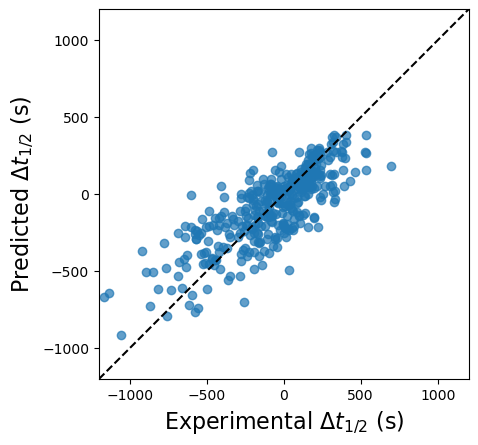

In [92]:
plt.plot(train_halftime_diff, train_halftime_diff_pred.reshape(-1,1) , 'o',alpha = 0.7,)
r2 = r2_score(train_halftime_diff, train_halftime_diff_pred.reshape(-1,1) )
mae = mean_absolute_error(train_halftime_diff,train_halftime_diff_pred.reshape(-1,1))
print(f'r2 score: {r2:0.2f}, MAE score: {mae:0.2f}')
plt.xlabel("Experimental $\Delta t_{1/2}$ (s)",fontsize = 16)
plt.ylabel("Predicted $\Delta t_{1/2}$ (s)",fontsize = 16)
y_line = np.linspace(-1200, 1200)
plt.plot(y_line, y_line, 'k--')
plt.xlim(-1200,1200)
plt.ylim(-1200,1200)
plt.gca().set_aspect('equal');

In [93]:
# calculate the halftime difference (L-TA - D-TA) on S surfaces and (D-TA - L-TA) on R
test_halftime_diff = y_lsdr_test.values - y_lrds_test.values
# calculate the halftime difference predictions
test_halftime_diff_pred = model_lsdr.predict(X_lsdr_test.values) - model_lrds.predict(X_lrds_test.values)

r2 score: 0.57, MAE score: 138.31


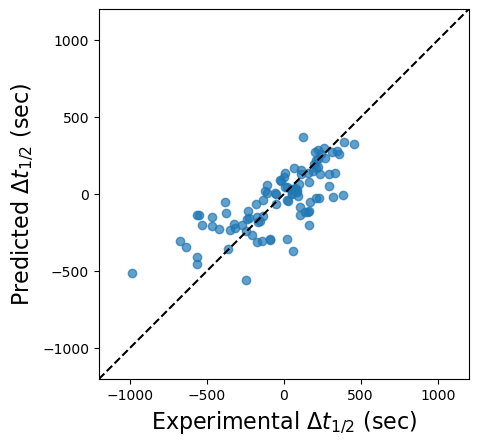

In [94]:
plt.plot(test_halftime_diff, test_halftime_diff_pred.reshape(-1,1), 'o',alpha = 0.7)
y_line = np.linspace(-1200, 1200)
plt.plot(y_line, y_line, 'k--')
r2 = r2_score(test_halftime_diff, test_halftime_diff_pred.reshape(-1,1))
mae = mean_absolute_error(test_halftime_diff, test_halftime_diff_pred.reshape(-1,1))
print(f'r2 score: {r2:0.2f}, MAE score: {mae:0.2f}')
plt.xlabel("Experimental $\Delta t_{1/2}$ (sec)",fontsize = 16)
plt.ylabel("Predicted $\Delta t_{1/2}$ (sec)",fontsize = 16)
plt.gca().set_aspect('equal')
plt.xlim(-1200,1200)
plt.ylim(-1200,1200)
plt.show()

In [95]:
## remove the xy stereographic projections to get the gcn features only
X_lsdr.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)
X_lrds.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)

#### It is simpler to get the halftime difference when you are training on the whole lsdr and lrds datasets without splitting to train and test. You can simply place the lsdr predictions in a lsdr dataframe and the lrds predictions in a lrds. Then, you can merge these two dataframes to get the original dataset with the correct ordering. Then, if you divide this dataset into D-TA dataframe and L-TA dataframe, you can get the halftime difference easily. 

In [96]:
def predictions_df(sample_df, model, X):
    ''' This function returns the combines predictions into a dataframe '''
    df_train = pd.DataFrame({"half_time" : model.predict(X).reshape(-1,)})
    return df_train

In [97]:
def combined_pred(lsdr_df, model_lsdr, X_lsdr, lrds_df, model_lrds, X_lrds):
    # Create dataframe of training labels and test labels predictions with the right indices 
    # and join to original dataframe for the lsdr model. 
    lsdr_pred  = predictions_df(lsdr_df, model_lsdr, X_lsdr,)
    lsdr_pred.set_index(lsdr_df.index, inplace=True)
    lsdr_df = lsdr_df.join(lsdr_pred["half_time"])
    lsdr_df.rename(columns={"half_time": "half_time_pred"}, inplace=True)
    # do the same thing for the lrds model
    lrds_pred  = predictions_df(lrds_df, model_lrds, X_lrds,)
    lrds_pred.set_index(lrds_df.index, inplace=True)
    lrds_df = lrds_df.join(lrds_pred["half_time"])
    lrds_df.rename(columns={"half_time": "half_time_pred"}, inplace=True)
    # Combine the two dataframes to get all the data back together
    pred_df = pd.merge(lsdr_df, lrds_df, "outer")
    # divide the dataframes into two dataframes, one for D-TA and one for L-TA
    lta_df = pred_df[pred_df['molecule'] == "L-TA"]
    lta_df  = lta_df.reset_index(drop=True)
    dta_df = pred_df[pred_df['molecule'] == "D-TA"]
    return lta_df, dta_df

In [98]:
lta_df, dta_df = combined_pred(df.loc[filt_lsdr], model_lsdr, X_lsdr, df.loc[filt_lrds], 
                               model_lrds, X_lrds)

In [99]:
# Get the halftime difference predictions for the (100) sample
df_100 = df[df["normal_miller_index"]== 100]
# get the dta halftimes for the (100) sample points
pred_100_dta = df_100[df_100["molecule"]=="D-TA"].merge(dta_df[dta_df["normal_miller_index"]== 100], on=["stereographic_projection_x", "stereographic_projection_y"])
# get the lta halftimes for the (100) sample points
pred_100_lta = df_100[df_100["molecule"]=="L-TA"].merge(lta_df[lta_df["normal_miller_index"]== 100], on=["stereographic_projection_x", "stereographic_projection_y"])
# calculate the halftime difference
delta_t_100 = pred_100_dta["half_time_pred"].values - pred_100_lta["half_time_pred"].values
# get the stereographic projections for plotting later
xy_100_p = df_100[df_100["molecule"]=="D-TA"][["stereographic_projection_x", "stereographic_projection_y"]].values

In [100]:
# Get the halftime difference predictions for the (111) sample
df_111 = df[df["normal_miller_index"]== 111]
# get the dta halftimes for the (111) sample points
pred_111_dta = df_111[df_111["molecule"]=="D-TA"].merge(dta_df[dta_df["normal_miller_index"]== 111], on=["stereographic_projection_x", "stereographic_projection_y"])
# get the lta halftimes for the (111) sample points
pred_111_lta = df_111[df_111["molecule"]=="L-TA"].merge(lta_df[lta_df["normal_miller_index"]== 111], on=["stereographic_projection_x", "stereographic_projection_y"])
# calculate the halftime difference
delta_t_111 = pred_111_dta["half_time_pred"].values - pred_111_lta["half_time_pred"].values
# get the stereographic projections for plotting 
xy_111_p = df_111[df_111["molecule"]=="D-TA"][["stereographic_projection_x", "stereographic_projection_y"]].values

In [105]:
# Get the halftime difference predictions for the (110) sample
df_110 = df[df["normal_miller_index"]== 110]
# get the dta halftimes for the (110) sample points
pred_110_dta = df_110[df_110["molecule"]=="D-TA"].merge(dta_df[dta_df["normal_miller_index"]== 110], on=["stereographic_projection_x", "stereographic_projection_y"])
# get the lta halftimes for the (110) sample points
pred_110_lta = df_110[df_110["molecule"]=="L-TA"].merge(lta_df[lta_df["normal_miller_index"]== 110], on=["stereographic_projection_x", "stereographic_projection_y"])
# calculate the halftime difference
delta_t_110 = pred_110_dta["half_time_pred"].values - pred_110_lta["half_time_pred"].values
# get the stereographic projections for plotting 
xy_110_p = pred_110_dta[["stereographic_projection_x", "stereographic_projection_y"]].values

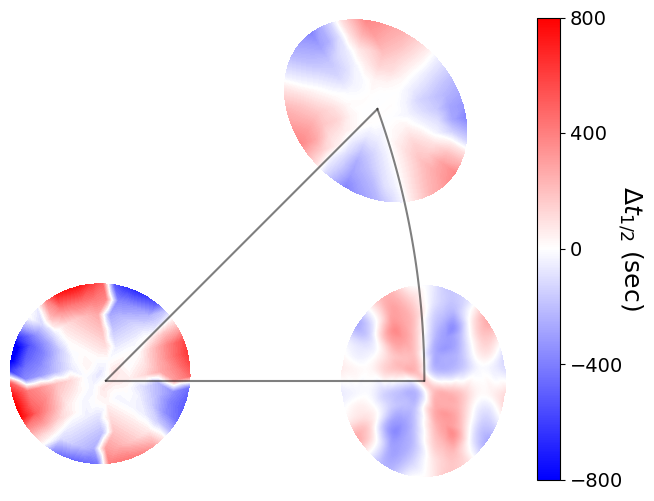

In [114]:
# plot the model predictions
fig, ax = plt.subplots(figsize=(8, 6))
norm = plt.Normalize(vmin=-800, vmax=800)
ax.tricontourf(xy_100_p[:,0], xy_100_p[:,1],delta_t_100.reshape(-1,),levels = 100,cmap='bwr', norm = norm)
ax.tricontourf(xy_111_p[:,0], xy_111_p[:,1],delta_t_111.reshape(-1,),levels = 100,cmap='bwr', norm = norm)

# plot the (110) sample using a different contour plot method because tricontourf leads to discontinuities in the plotting. 
x, y, z = xy_110_p[:,0], xy_110_p[:,1], delta_t_110
# Define grid with more points for smoother interpolation
xi = np.linspace(min(x), max(x), 1000)
yi = np.linspace(min(y), max(y), 1000)
xi, yi = np.meshgrid(xi, yi)
# Interpolate data onto grid using cubic interpolation for smoother results
zi = griddata((x, y), z, (xi, yi), method='cubic')
im = ax.imshow(zi, origin='lower', extent=[min(x), max(x), min(y), max(y)],
               vmin=-800, vmax=800, cmap='bwr')

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="bwr"), ax = ax,orientation="vertical")
cbar.set_ticks(np.linspace(-800, 800, 5))
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("$\Delta{t_{1/2}}$ (sec)", fontsize= 18,rotation=270)
#Draw the stereograhic triangle
x_values_1 = 0, 0.76235
y_values_1 =  0, 0
plt.plot(x_values_1, y_values_1, 'k', linestyle="-", alpha = 0.5)
x_values_2 = 0, 0.65
y_values_2 =  0, 0.65
plt.plot(x_values_2, y_values_2, 'k', linestyle="-", alpha = 0.5)
point1 = [0.65,  0.65]
point2 = [0, 0.76235]
y_1,x_1 = hanging_line(point1, point2)
plt.plot(x_1,y_1,'k', linestyle="-", alpha = 0.5)

ax.axis('off')
plt.gca().set_aspect('equal')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()

### Extrapolate to the rest of the stereographic triangle

In [151]:
full_triangle_predictions = pd.read_csv("data/full_triangle_gcn_features.csv")
full_triangle_predictions_2 =  full_triangle_predictions.query("surface_chirality!='A'")
# get the miller indices, stereographic projections and halftime difference predictions
full_triangle_predictions_2.drop_duplicates(["stereo_x", "stereo_y"], inplace = True)
final_miller_idx = full_triangle_predictions_2[["h", "k", "l"]].values
new_xy_p = full_triangle_predictions_2[["stereo_x", "stereo_y"]].values

In [152]:
df_1 = full_triangle_predictions_2.copy()
df_1["molecule"] = "D-TA"
df_2 = full_triangle_predictions_2.copy()
df_2["molecule"] = "L-TA"
df = pd.concat([df_1, df_2])

In [153]:
#Filter data into two groups
#Group 1 - L-TA on S Surface or D-TA on R Surface
filt_l_on_s = (df['molecule'] == "L-TA") & (df['surface_chirality'] == "S")
filt_d_on_r = (df['molecule'] == "D-TA") & (df['surface_chirality'] == "R")
filt_lsdr = np.logical_or(filt_l_on_s, filt_d_on_r)
#Group 2 - L-TA on R Surface or D-TA on S Surface
filt_l_on_r = (df['molecule'] == "L-TA") & (df['surface_chirality'] == "R")
filt_d_on_s = (df['molecule'] == "D-TA") & (df['surface_chirality'] == "S")
filt_lrds = np.logical_or(filt_l_on_r, filt_d_on_s)

In [154]:
#Extract Features 
X_lsdr = df.loc[filt_lsdr, 'GCN Density 4.75' : 'GCN Density 9.75']
X_lrds = df.loc[filt_lrds, 'GCN Density 4.75' : 'GCN Density 9.75']

In [155]:
lta_df, dta_df = combined_pred(df.loc[filt_lsdr], model_lsdr, X_lsdr.values, 
                               df.loc[filt_lrds], model_lrds, X_lrds.values)
new_labels = dta_df["half_time_pred"].values - lta_df["half_time_pred"].values
full_triangle_predictions_2["half_time_pred"] = new_labels
new_new_xy_p = np.concatenate((new_xy_p, full_triangle_predictions.query("surface_chirality=='A'")[["stereo_x", "stereo_y"]].values), axis=0)
new_new_labels = np.concatenate((new_labels,np.zeros((len(full_triangle_predictions.query("surface_chirality=='A'"))))), axis=0)

In [156]:
print("Max differnce", np.max(new_labels), ", Min difference", np.min(new_labels))

Max differnce 1592.2759175684073 , Min difference -909.2973384131402


In [157]:
# the surface with the highest absolute value of the halftime difference
print("maximum surface: ", np.round_(final_miller_idx[np.where(new_labels == np.max(np.abs(new_labels)))]/0.08737041))

maximum surface:  [[11.  3.  1.]]


Locator attempting to generate 1002 ticks ([-910.0, ..., 1592.5]), which exceeds Locator.MAXTICKS (1000).


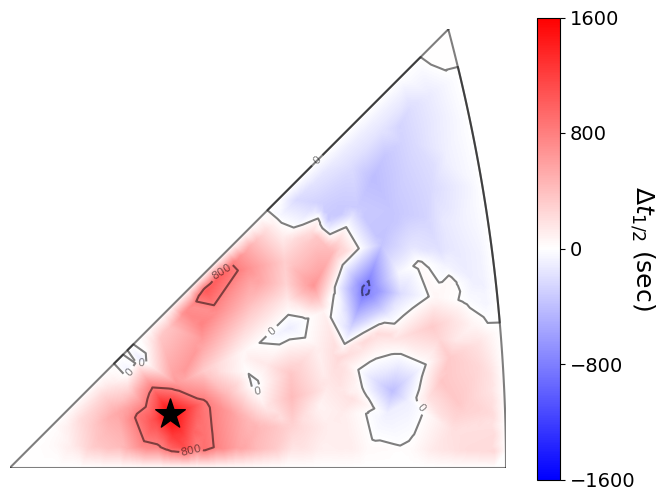

In [158]:
fig, ax = plt.subplots(figsize=(8, 6))
norm = matplotlib.colors.Normalize(vmin=-1600, vmax=1600)
ax.tricontourf(new_new_xy_p[:,0], new_new_xy_p[:,1],new_new_labels,levels = 1000,cmap='bwr', norm = norm)
# # Add contour lines at constant values
contour_lines = plt.tricontour(new_new_xy_p[:,0], new_new_xy_p[:,1],new_new_labels, levels=np.linspace(-1600, 1600, 5), 
colors='k', alpha=0.5,)

# # Add labels to contour lines
plt.clabel(contour_lines, inline=True, fontsize=8)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="bwr"), ax = ax,orientation="vertical")
cbar.set_ticks(np.linspace(-1600, 1600, 5))
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("$\Delta{t_{1/2}}$ (sec)", fontsize= 18,rotation=270)
#Draw the stereograhic triangle
x_values_1 = 0, 0.414214
y_values_1 =  0, 0
ax.plot(x_values_1, y_values_1, 'k', linestyle="-", alpha = 0.5)
x_values_2 = 0, 0.366025
y_values_2 =  0, 0.366025
ax.plot(x_values_2, y_values_2, 'k', linestyle="-", alpha = 0.5)
point1 = [0.366025, 0.366025]
point2 = [0, 0.414214]
y_1,x_1 = hanging_line(point1, point2)
ax.plot(x_1,y_1,'k', linestyle="-", alpha = 0.5)

# highlight the GCN optimal surface 
ax.scatter(new_new_xy_p[:,0][np.where(new_new_labels == np.max(new_new_labels))[0]], 
        new_new_xy_p[:,1][np.where(new_new_labels == np.max(new_new_labels))[0]], c = 'k',  s=500,  edgecolors='black', marker="*") #label = f"{max_miller}",

ax.axis('off')
plt.gca().set_aspect('equal')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()

## Uncertainty in the data
### train 1000 models on different data splits and use their statistics to get uncertainity in the optimal value and the optimal location. 

In [146]:
optimal_locations = []
optimal_value = []
coef = []
all_labels = []
for i in np.random.randint(50000, size=100):
    df = df_full[df_full["surface_chirality"]!="A"]
    #Filter data into two groups
    #Group 1 - L-TA on S Surface or D-TA on R Surface
    filt_l_on_s = (df['molecule'] == "L-TA") & (df['surface_chirality'] == "S")
    filt_d_on_r = (df['molecule'] == "D-TA") & (df['surface_chirality'] == "R")
    filt_lsdr = np.logical_or(filt_l_on_s, filt_d_on_r)
    #Group 2 - L-TA on R Surface or D-TA on S Surface
    filt_l_on_r = (df['molecule'] == "L-TA") & (df['surface_chirality'] == "R")
    filt_d_on_s = (df['molecule'] == "D-TA") & (df['surface_chirality'] == "S")
    filt_lrds = np.logical_or(filt_l_on_r, filt_d_on_s)
    #Extract Features 
    X_lsdr = df.loc[filt_lsdr, 'stereographic_projection_x' : 'GCN Density 9.75']
    X_lrds = df.loc[filt_lrds, 'stereographic_projection_x' : 'GCN Density 9.75']
    #Extract Labels
    y_lsdr = df.loc[filt_lsdr, 'halftime(s)': "stereographic_projection_y"]
    y_lrds = df.loc[filt_lrds, 'halftime(s)': "stereographic_projection_y"]
    chiral_lsdr = df.loc[filt_lsdr, 'surface_chirality']
    #Split Data
    X_lsdr_train, X_lsdr_test, y_lsdr_train, y_lsdr_test = train_test_split(X_lsdr, y_lsdr, test_size=0.2, random_state=i)

    # first you merge on lsdr train split based on stereo_x and stereo_y
    X_lrds_train = pd.merge(X_lsdr_train, X_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
    # second you get rid of the lsdr features and the stereo_x and stereo_y columns which are the first 60 columns
    X_lrds_train = X_lrds_train.iloc[:,60:]
    # same procedure is done for the test features
    X_lrds_test  = pd.merge(X_lsdr_test, X_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
    X_lrds_test = X_lrds_test.iloc[:,60:]

    # same idea for the lrds train labels
    y_lrds_train = pd.merge(y_lsdr_train, y_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
    # here you remove the last two columns which are the stereo_x and stereo_y and the halftime for the lsrd dataset columns
    y_lrds_train = y_lrds_train.iloc[:,3:]
    # same idea for the lrds test labels
    y_lrds_test = pd.merge(y_lsdr_test, y_lrds, on = ["stereographic_projection_x", "stereographic_projection_y"], how = "inner")
    y_lrds_test = y_lrds_test.iloc[:,3:]
    
    # remove the stereo_x and stereo_y columns from the lsdr and lrds train and test features
    X_lsdr_train.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)
    X_lsdr_test.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)

    y_lsdr_train.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)
    y_lsdr_test.drop(columns=["stereographic_projection_x", "stereographic_projection_y"], axis=1, inplace=True)   
    

    model_lsdr_new  = Ridge(alpha=best_alpha)
    model_lrds_new = Ridge(alpha=best_alpha) 
    
    #Fit models
    model_lsdr_new.fit(X_lsdr_train.values, y_lsdr_train)
    model_lrds_new.fit(X_lrds_train.values, y_lrds_train)
    
    
    df = pd.concat([df_1, df_2])
    #Filter data into two groups
    #Group 1 - L-TA on S Surface or D-TA on R Surface
    filt_l_on_s = (df['molecule'] == "L-TA") & (df['surface_chirality'] == "S")
    filt_d_on_r = (df['molecule'] == "D-TA") & (df['surface_chirality'] == "R")
    filt_lsdr = np.logical_or(filt_l_on_s, filt_d_on_r)
    #Group 2 - L-TA on R Surface or D-TA on S Surface

    filt_l_on_r = (df['molecule'] == "L-TA") & (df['surface_chirality'] == "R")
    filt_d_on_s = (df['molecule'] == "D-TA") & (df['surface_chirality'] == "S")
    filt_lrds = np.logical_or(filt_l_on_r, filt_d_on_s)
    
    #Extract Features 
    X_lsdr = df.loc[filt_lsdr, 'GCN Density 4.75' : 'GCN Density 9.75']
    X_lrds = df.loc[filt_lrds, 'GCN Density 4.75' : 'GCN Density 9.75']
    
    lta_df, dta_df = combined_pred(df.loc[filt_lsdr], model_lsdr_new, X_lsdr.values, df.loc[filt_lrds], model_lrds_new, X_lrds.values)
    new_labels = dta_df["half_time_pred"].values - lta_df["half_time_pred"].values
    full_triangle_predictions_2["half_time_pred"] = new_labels
    new_new_labels = np.concatenate((new_labels,np.zeros((len(full_triangle_predictions.query("surface_chirality=='A'"))))), axis=0)
    
    optimal_locations.append(new_xy_p[np.where(new_labels == np.max(new_labels))[0][0]])
    optimal_value.append(np.max(new_labels))
    all_labels.append(new_new_labels)

optimal_locations = np.array(optimal_locations)
optimal_value = np.array(optimal_value)
coef = np.array(coef)
all_labels = np.array(all_labels)

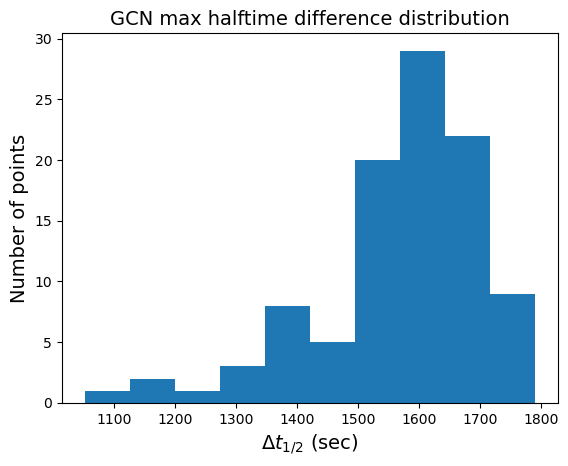

In [147]:
plt.hist(optimal_value, density=False, bins=10)  
plt.xlabel("$\Delta{t_{1/2}}$ (sec)", fontsize = 14)
plt.ylabel("Number of points", fontsize = 14)
plt.title("GCN max halftime difference distribution", fontsize = 14)
plt.show()

In [148]:
count = []
unique_opts = []
mean_opt_value = []
std_opt_value = []
unique_miller_indices = []
for j in np.unique(optimal_locations[:,0]):
    count.append(len(np.where(optimal_locations[:,0] == j)[0]))
    unique_opts.append(optimal_locations[np.where(optimal_locations[:,0] == j)[0][0]])
    mean_opt_value.append(np.mean(optimal_value[np.where(optimal_locations[:,0] == j)[0]]))
    std_opt_value.append(np.std(optimal_value[np.where(optimal_locations[:,0] == j)[0]]))
    unique_miller_indices.append(final_miller_idx[np.where(optimal_locations[:,0] == j)[0][0]])
unique_opts = np.array(unique_opts)

In [149]:
np.mean(np.max(all_labels, axis =1)), np.std(np.max(all_labels, axis =1))

(1570.196197663664, 140.21276400628003)

In [150]:
np.mean(np.min(all_labels, axis =1))

-943.7178621963678

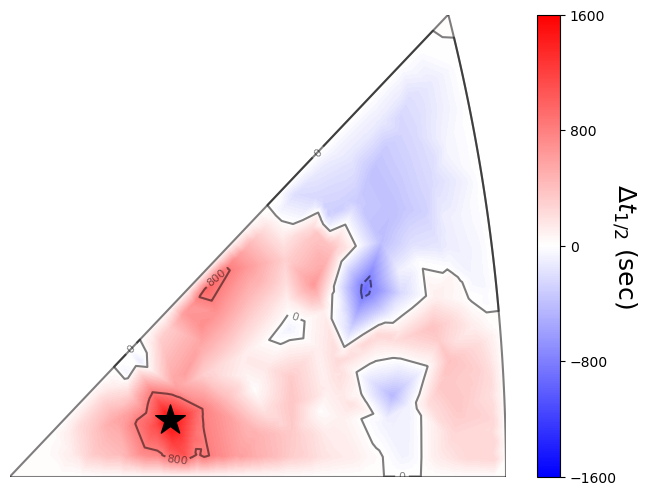

In [151]:
fig, ax = plt.subplots(figsize=(8, 6))
norm = matplotlib.colors.Normalize(vmin=-1600, vmax=1600)
ax.tricontourf(new_new_xy_p[:,0], new_new_xy_p[:,1],np.mean(all_labels, axis =0),levels = 100,cmap='bwr', norm = norm)
# Add contour lines at constant values
contour_lines = plt.tricontour(new_new_xy_p[:,0], new_new_xy_p[:,1],np.mean(all_labels, axis =0), levels=np.linspace(-1600, 1600, 5), 
colors='k', alpha=0.5,)

# Add labels to contour lines
plt.clabel(contour_lines, inline=True, fontsize=8)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap="bwr"), ax = ax,orientation="vertical")
cbar.set_ticks(np.linspace(-1600, 1600, 5))
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("$\Delta{t_{1/2}}$ (sec)", fontsize= 18,rotation=270)
ax.scatter(unique_opts[:,0], unique_opts[:,1], c = "k", marker="*", s = np.array(count)*5,)
ax.axis('off')
#Draw the stereograhic triangle
x_values_1 = 0, 0.414214
y_values_1 =  0, 0
ax.plot(x_values_1, y_values_1, 'k', linestyle="-", alpha = 0.5)
x_values_2 = 0, 0.366025
y_values_2 =  0, 0.366025
ax.plot(x_values_2, y_values_2, 'k', linestyle="-", alpha = 0.5)
point1 = [0.366025, 0.366025]
point2 = [0, 0.414214]
y_1,x_1 = hanging_line(point1, point2)
ax.plot(x_1,y_1,'k', linestyle="-", alpha = 0.5)
# hide the axes
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.show()

### Trend between the surface structure and the predicted halftime difference

In [159]:
important_feat = full_triangle_predictions_2[['GCN Density 4.75', "GCN Density 9.333", 
                                              'GCN Density 6.417', "GCN Density 5.583",]].values
important_feat_sum = full_triangle_predictions_2[['GCN Density 4.75', "GCN Density 9.333", 
                                                  'GCN Density 6.417', "GCN Density 5.583", ]].values.sum(axis = 1) 

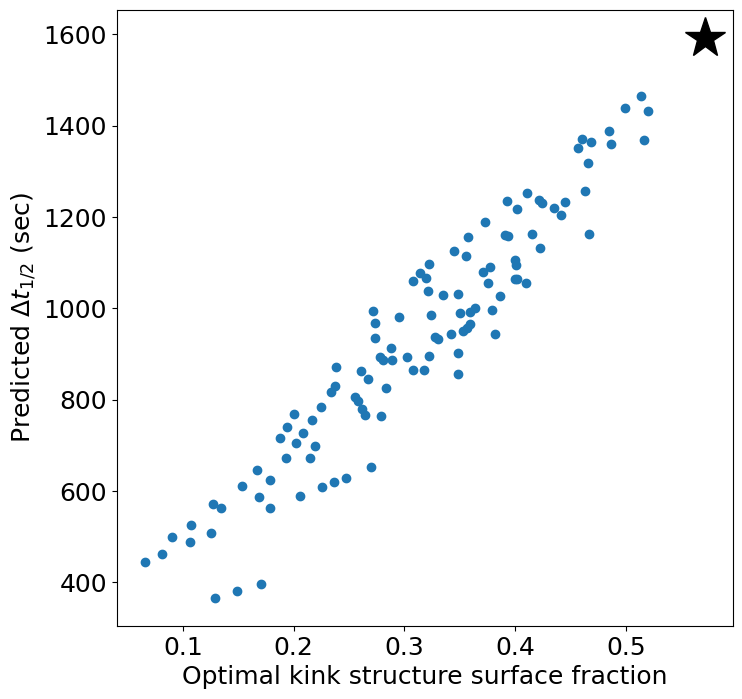

In [162]:
fig, ax = plt.subplots(figsize=(8, 8)) 
ax.plot(important_feat_sum[np.where(np.product(important_feat, axis = 1)!=0)], new_labels[np.where(np.product(important_feat, axis = 1)!=0)], "o", alpha = 1)
ax.plot(important_feat_sum[np.where(new_labels == np.max(np.abs(new_labels)))[0]], np.abs(new_labels)[np.where(new_labels == np.max(np.abs(new_labels)))[0]],"k*",markersize=30)
ax.set_xlabel("Optimal kink structure surface fraction",fontsize = 18)
ax.set_ylabel("Predicted $\Delta{t_{1/2}}$ (sec)",fontsize = 18)
plt.gca().set_aspect('equal')
ax.set_aspect(np.diff(ax.get_xlim())/np.diff(ax.get_ylim()))
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18);

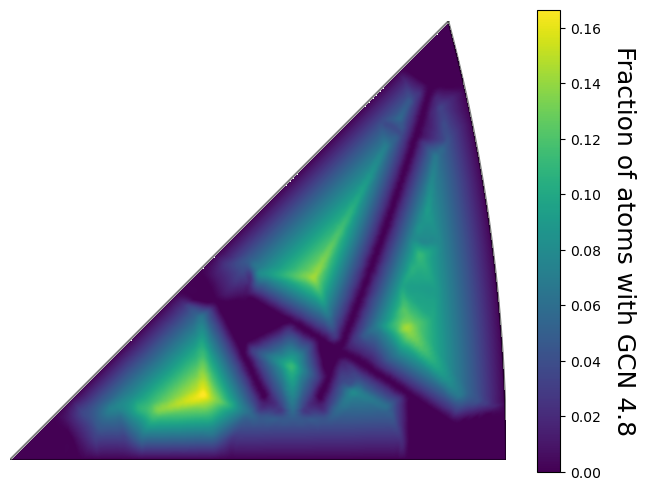

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

GCN_VALUE = 'GCN Density 4.75'

x, y, z = full_triangle_predictions["stereo_x"].values, \
full_triangle_predictions["stereo_y"].values, \
full_triangle_predictions[GCN_VALUE].values

# Define grid with more points for smoother interpolation
xi = np.linspace(min(x), max(x), 1000)
yi = np.linspace(min(y), max(y), 1000)
xi, yi = np.meshgrid(xi, yi)

# Interpolate data onto grid using cubic interpolation for smoother results
zi = griddata((x, y), z, (xi, yi), method='cubic')

# Create contour plot
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(zi, origin='lower', extent=[min(x), max(x), min(y), max(y)],
               vmin=0, vmax=np.max(z), )#cmap = "Reds"
cbar = fig.colorbar(im, ax=ax, orientation="vertical")
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_ylabel("Fraction of atoms with GCN 4.8", fontsize= 18,rotation=270)

#Draw the stereograhic triangle
x_values_1 = 0, 0.414214
y_values_1 =  0, 0
plt.plot(x_values_1, y_values_1, 'k', linestyle="-", alpha = 0.5)
x_values_2 = 0, 0.366025
y_values_2 =  0, 0.366025
plt.plot(x_values_2, y_values_2, 'k', linestyle="-", alpha = 0.5)
point1 = [0.366025, 0.366025]
point2 = [0, 0.414214]
y_1,x_1 = hanging_line(point1, point2)
plt.plot(x_1,y_1,'k', linestyle="-", alpha = 0.5)

# Configure plot appearance
ax.axis('off')
plt.gca().set_aspect('equal')
plt.show()